In [1]:
import math
import time

from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
from numpy.ma.extras import average

from scipy import fft
from tensorboard.compat.tensorflow_stub.errors import OutOfRangeError
from tqdm import tqdm
from collections import defaultdict

#%matplotlib notebook
#%matplotlib widget
%matplotlib ipympl
#%matplotlib inline


In [2]:
dataset_path = "../../Data/OscData2.csv"
#dataset_path = "../../Data/datset_v1.csv"
period_size = 32
window_period_cnt = 4
wsz = period_size * window_period_cnt
data_channel = 3
etal_sim_th = 0.5  # max value of standard deviation with etalon
file_prefix = ""
#file_prefix = "b629f3bb07ef79f5845c27daa0a83425"
#file_prefix = "0a3cba1c0d3a410500489925e5282827"

feats = ["IA", "IC", "UA BB", "UB BB", "UC BB"]  #, "UN BB"
#feats = ["UA BB", "UB BB", "UC BB", "UN BB"]

adjust_ampl_feats = {"IA", "IB", "IC"}  # "UN BB"
adjust_ampl_factor = 2


In [3]:

x_fft = fft.rfftfreq(wsz, 1.0 / period_size)
fftsz = len(x_fft)
etal_weight = np.ones(fftsz)

window_func = np.hanning(wsz)
window_func /= np.sqrt(np.average(window_func ** 2))

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
data = pd.read_csv(dataset_path)
op_names = ['opr_swch', 'abnorm_evnt', 'emerg_evnt', 'normal']

data[op_names] = data[op_names].fillna(value=0)
data.fillna({"IB": 0}, inplace=True)
data.dropna(axis=1, how='any', inplace=True)

files = np.unique(data["file_name"].values)
matching_files = [x for x in files if x.startswith(file_prefix)]

print(f"Found {len(matching_files)} matching sequences")

target_file = matching_files[1]
data = data[data["file_name"] == target_file]

print(f"Working with file {target_file}")


Found 66 matching sequences
Working with file 031064763a753380d14b0526a0208858_Bus 2 _event N1


In [5]:
len(data)

667

In [6]:
channel_ampls = defaultdict(lambda: 1, {
    "IA": 1,
    "IB": 1,
    "IC": 1,
    "UA BB": 84.5,
    "UB BB": 84.5,
    "UC BB": 84.5,
    "UN BB": 1,
})

gr_feat = data.columns[data_channel]

data_feat = data[gr_feat].values




In [7]:
def norm_fft(seq, window_func=None):
    n = len(seq)
    if window_func is None:
        window_func = np.ones_like(seq)

    res = np.abs(fft.rfft(seq * window_func) / n)
    res[1:] *= 2
    return res


def energy_diff(seq1, seq2, weights=None):  # sqrt(wave power difference)
    if weights is None:
        weights = np.ones(len(seq1))

    return np.sqrt(np.sum((np.abs((seq1 ** 2) - (seq2 ** 2))) * weights))


def etalon_cosine(n=wsz, amplitude=1):
    return norm_fft(amplitude * np.cos(np.linspace(0, 2 * np.pi * n / period_size, n, endpoint=False)),
                    window_func=window_func)


In [8]:
#etal0 = (np.zeros(fftsz), np.concatenate((np.ones(window_period_cnt + 1), np.zeros(fftsz - window_period_cnt - 1))))
etal0 = np.zeros(fftsz)

#etal1 = (np.zeros(fftsz), np.concatenate((np.ones(window_period_cnt + 1), np.zeros(fftsz - window_period_cnt - 1))))
etal1 = etalon_cosine(wsz, amplitude=1)

In [9]:
#%matplotlib ipympl
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(12, 8)
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.1, right=0.95, hspace=0.4)

#rep_cnt = 30
# X = np.sin(np.linspace(0, 2 * np.pi * rep_cnt, period_size * rep_cnt,
#                        endpoint=False)) + np.sin(
#     np.linspace(0, 1 * np.pi * rep_cnt, period_size * rep_cnt, endpoint=False))
#X += np.ones_like(X)

ax1.set_title(f"Signal ({gr_feat})")
ax1.set_ylim(-2, 2)
p1, = ax1.plot([], [], label="Signal")
p1_et, = ax1.plot([], [], label="Etalon", linestyle="--")

ax2.set_title("Windowed signal")
ax2.set_ylim(-2, 2)
p2, = ax2.plot([], [], label="Windowed signal")

ax3.set_yscale('log')
ax3.set_xlim((0, np.max(x_fft)))
ax3.set_ylim((0.01, 2))
#plt.ylim((0, 2))

sim0 = []
sim1 = []

ax3.set_title("Spectrum")
p3, = ax3.plot(x_fft, [0] * fftsz, label="Spectrum")
p3_e1, = ax3.plot(x_fft, etal1, label="Etalon", color="black")
#p3_w, = ax3.plot(x_fft, etal_weight)
p3_d2, = ax3.plot(x_fft, np.zeros(fftsz), label="Energy difference", color="red")

ax3.legend()

ax4.set_title("Pattern error")
ax4.set_xlim((0, wsz))
ax4.set_yscale('log')
ax4.set_ylim((0.1, 2))
p4_0, = ax4.plot([], [], color="blue", label="off etalon")
p4_1, = ax4.plot([], [], color="red", label="sine etalon")
p4_th, = ax4.plot([-1000000, 1000000], [etal_sim_th, etal_sim_th], label="Threshold", linestyle="--")
#p4_state, = ax4.plot(range(wsz), np.ones(wsz))
ax4.legend()
ax4.grid(True)


# lpos=0
# p1_et.set_xdata(range(lpos, lpos + wsz))
# p1_et.set_ydata(np.cos(np.linspace(0, 2 * np.pi * wsz / period_size, wsz, endpoint=False)))
# #print(etal0[1])


def update(frame):
    lpos = frame
    seq = data_feat[lpos:lpos + wsz].copy()
    #seq=np.zeros_like(seq)
    ampl = channel_ampls[gr_feat]

    if gr_feat in adjust_ampl_feats:
        sig_ampl = np.average(np.abs(seq)) * np.pi / 2
        dif = sig_ampl / ampl
        ampl *= np.clip(dif, 1 / adjust_ampl_factor, adjust_ampl_factor)
        p1_et.set_xdata(range(lpos, lpos + wsz))
        p1_et.set_ydata(np.cos(np.linspace(0, 2 * np.pi * wsz / period_size, wsz, endpoint=False)) * sig_ampl / ampl)

    seq /= ampl

    seq_wind = seq * window_func
    spec = norm_fft(seq, window_func)

    ax1.set_xlim(lpos, lpos + wsz)
    ax2.set_xlim(lpos, lpos + wsz)
    ax4.set_xlim(lpos, lpos + wsz)

    p1.set_xdata(range(lpos, lpos + wsz))
    p1.set_ydata(seq)

    p2.set_xdata(range(lpos, lpos + wsz))
    p2.set_ydata(seq_wind)

    p3.set_ydata(spec)
    p3_d2.set_ydata(np.sqrt(np.abs((spec ** 2) - (etal1 ** 2))))

    sim0.append(energy_diff(etal0, spec, weights=etal_weight))
    sim1.append(energy_diff(etal1, spec, weights=etal_weight))

    lsim = lpos + wsz - min(len(sim0), wsz)
    p4_0.set_xdata(range(lsim, lpos + wsz))
    p4_0.set_ydata(sim0[-min(len(sim0), wsz):])

    p4_1.set_xdata(range(lsim, lpos + wsz))
    p4_1.set_ydata(sim1[-min(len(sim1), wsz):])

    return p1, p2, p3, p4_0, p4_1, p4_th,


ani = FuncAnimation(fig, update, frames=range(1, 20800), interval=1, blit=True, repeat=False)
#plt.show()


<IPython.core.display.Javascript object>

In [1]:
etal1

NameError: name 'etal1' is not defined

In [10]:
dataset_path = "../../Data/OscData2.csv"
save_path = "../../Data/OscData2"

period_size = 32
window_period_cnt = 8
wsz = period_size * window_period_cnt
etal_sim_th = -1  # 0.5  # max value of standard deviation with etalon, recommended to leave only abnormal events: 0.5

wcnt = 3  # number of spectrum recordings in generated data
capwsz = wsz  # size of window of recordings
wshift = capwsz // 2  # shift between recordings
unmatched_channels_th = 3  # threshold which states the least number of unmatched channels for measure to be considered abnormal
capture_step = 7  # step between recordings
adjust_ampl_factor = 2  # features from adjust_ampl_feats have adaptive amplitude scale from 1/fac to fac



viewsz = capwsz + wshift * (wcnt - 1)
lpadding = (viewsz - wsz)
feats = ["UA BB", "UB BB", "UC BB"]  # ["IA", "IC", "UA BB", "UB BB", "UC BB"]  # , "UN BB"
adjust_ampl_feats = {"IA", "IC"}  # "UN BB"
x_fft = fft.rfftfreq(wsz, 1.0 / period_size)
specsz = len(x_fft)
etal_weight = np.ones(specsz)
window_func = np.hanning(wsz)
window_func /= np.sqrt(np.average(window_func ** 2))
cap_window_func = np.hanning(capwsz)

channel_ampls = defaultdict(lambda: 1, {
    "IA": 1,
    "IB": 1,
    "IC": 1,
    "UA BB": 84.5,
    "UB BB": 84.5,
    "UC BB": 84.5,
    "UN BB": 1,
})

op_names = ['opr_swch', 'abnorm_evnt', 'emerg_evnt', 'normal']


In [11]:
def match_etal(lpos, data_track, wsz=wsz, window_func=window_func):
    seq_trim = data_track[lpos:lpos + wsz]
    nomatch = []

    for feat in feats:
        seq = seq_trim[feat].values.copy()
        ampl = channel_ampls[feat]

        if feat in adjust_ampl_feats:
            sig_ampl = np.average(np.abs(seq)) * np.pi / 2
            dif = sig_ampl / ampl
            ampl *= np.clip(dif, 1 / adjust_ampl_factor, adjust_ampl_factor)

        seq /= ampl
        spec = norm_fft(seq, window_func)

        sim0 = energy_diff(etal0, spec, weights=etal_weight)
        sim1 = energy_diff(etal1, spec, weights=etal_weight)

        if min(sim0, sim1) > etal_sim_th:
            nomatch.append(feat)
    return nomatch


def gen_case(starttime, data_track, wcnt=wcnt, window_func=cap_window_func, capwsz=capwsz, wshift=wshift):
    measures = []

    for lpos in range(starttime, starttime + wshift * wcnt, wshift):
        rpos = lpos + capwsz
        if lpos < 0 or rpos >= len(data):
            raise IndexError("Wrong time interval for case generation")

        seq_trim = data_track[lpos:lpos + capwsz]
        spectrums = []

        for feat in feats:
            seq = seq_trim[feat].values.copy()
            ampl = channel_ampls[feat]
            seq /= ampl
            spec = norm_fft(seq, window_func)
            spectrums.append(spec)

        measures.append(spectrums)
    return np.array(measures)

In [12]:
import pandas as pd
def process_file(filename: str):
    data_track = data[data["file_name"] == filename]

    wtf = gen_case(0, data_track=data_track, wcnt=wcnt, window_func=cap_window_func, capwsz=capwsz,
                            wshift=wshift)
    print(wtf.shape)
    plt.plot(etal1)
    # for i in range(wtf.shape[1]):
    #     plt.plot(wtf[0, i])
    plt.show()
    exit(0)

  0%|          | 0/66 [00:00<?, ?it/s]

(3, 3, 129)


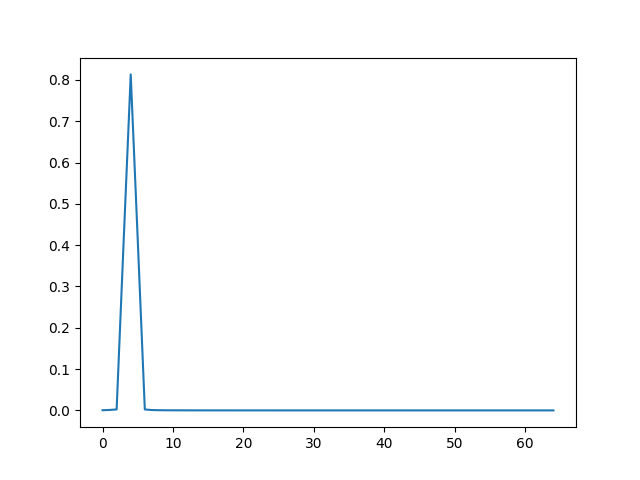

  0%|          | 0/66 [00:00<?, ?it/s]


TypeError: cannot unpack non-iterable NoneType object

In [13]:
data = pd.read_csv(dataset_path)
data[op_names] = data[op_names].fillna(value=0)
# data.fillna({"IB": 0}, inplace=True)
data.dropna(axis=1, how='any', inplace=True)
files = np.unique(data["file_name"].values)

X, y = np.ndarray((0, wcnt, len(feats), (capwsz // 2) + 1)), np.array([])

for filename in tqdm(files):
    # filename="b629f3bb07ef79f5845c27daa0a83425_Bus 2 _event N1"
    # print(f"Working with file {filename}")
    tX, ty = process_file(filename)
    break

In [15]:
print(X.shape)
print(y.shape)
print(y)

(0,)
(0,)
[]


In [13]:
%matplotlib inline

lpos = 420
seq = X[lpos:lpos + wsz].copy()
ampl = channel_ampls[gr_feat]
seq /= ampl
seq_wind = seq * window_func
spec = norm_fft(seq, window_func)

plt.figure(figsize=(12, 8))
plt.xlim((0, 20))
plt.ylim((0.01, 1))
plt.grid(which='both')
plt.yscale('log')
plt.plot(spec, label="Spectrum")
plt.plot(etal1, label="Etalon")
plt.plot(spec - etal1, label="Dif")
plt.plot(np.abs((spec ** 2) - (etal1 ** 2)), label="2 Dif")
plt.legend()
plt.show()

NameError: name 'X' is not defined

In [34]:
lpos = 2200
seq = X[lpos:lpos + wsz]
ampl = channel_ampls[gr_feat]
feat = "UN BB"
if feat in adjust_ampl_feats:
    sig_ampl = np.average(np.abs(seq)) * np.pi / 2
    dif = sig_ampl / ampl
    # ampl *= np.clip(dif, 1 / adjust_ampl_factor, adjust_ampl_factor)
    p1_et.set_xdata(range(lpos, lpos + wsz))
    p1_et.set_ydata(np.cos(np.linspace(0, 2 * np.pi * wsz / period_size, wsz, endpoint=False) * sig_ampl / ampl))

seq /= ampl
seq_wind = seq * window_func
spec = norm_fft(seq, window_func)
print(spec)

TypeError: unsupported operand type(s) for /=: 'list' and 'float'

In [35]:
lsim = lpos + wsz - max(len(sim0), wsz)
ax4.set_xdata(range(lsim, lpos + wsz))
ax4.set_ydata(sim0[-max(len(sim0), wsz):])

AttributeError: 'Axes' object has no attribute 'set_xdata'

In [153]:
lpos = 250
rpos = lpos + 128
seq_trim = data[lpos:lpos + wsz]
events = data[op_names[:3]][lpos:rpos]

print(np.any(events))
print(events.shape)
print(events)

True
(128, 3)
       opr_swch  abnorm_evnt  emerg_evnt
48698       0.0          0.0         0.0
48699       0.0          0.0         0.0
48700       0.0          0.0         0.0
48701       0.0          0.0         0.0
48702       0.0          0.0         0.0
...         ...          ...         ...
48821       0.0          0.0         0.0
48822       0.0          0.0         0.0
48823       0.0          0.0         0.0
48824       0.0          0.0         0.0
48825       0.0          0.0         0.0

[128 rows x 3 columns]


In [161]:
events.mean().mean()

np.float64(0.13541666666666666)